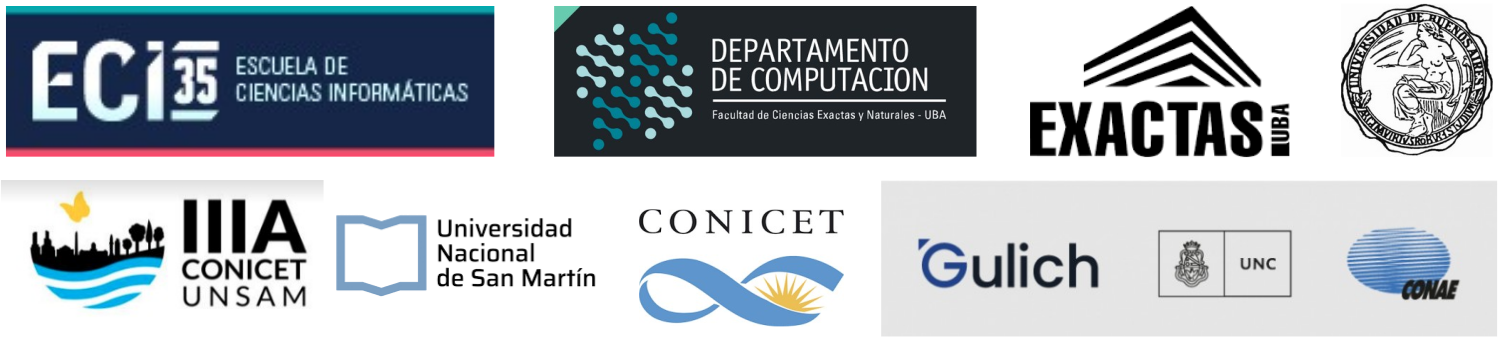
# Escuela de Ciencias Informáticas - 2022 - DC - FCEN - UBA
## Curso: Procesamiento de Imágenes Satelitales.  Docente: Rafael Grimson


---
#  Notebook 8: Un sitio de estudio. ROIS y Máscaras
---
Lo que veremos en esta notebook:

- [x] Imágenes (no satelitales). Las imágenes expresadas como array
- [x] Representación de una imagen en niveles de gris
- [x] Resolución de una imagen
---
Rasterio
propiedades de imagenes satelitales
visualizacion de una banda
visualización color, falso color
nequialize
algebra de bandas, indices

### Objetivos de la notebook:

- En esta notebook esperamos que aprendas a mirar en conjunto datos raster y ROIS vectoriales.

### Datos con los que trabajaremos en esta Notebook:

- La imagen Sentinel-2 del Dique Roggero en formato original comprimido 
    - **'L1C_T21HUB_A017181_20181006T135109.zip'**
    - **-L1C_T21HUB_A023044_20191120T135113.zip**
- Capa vectorial
    - **zona_dique.geojson**
    - **rois_dique.geojson**

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import rasterio
import rasterio.mask

from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask

import geopandas as gpd
#from shapely.geometry import mapping

import pandas as pd
import seaborn as sns

data_dir = 'data/raw_data/'
path_proc = 'data/proc/'
path_out = 'data/out/'
path_shp = 'data/raw_data/vector/'

from funciones import *


In [2]:
#Recordemos que podemos hacer un clip unsa Sentinel2 a partir de un vectorial usando
mbb_dique = compute_mbb(path_shp+'zona_dique.geojson', grid_step = 100)

In [3]:
fn_zip='L1C_T21HUB_A017181_20181006T135109.zip'
S2_dique_20181006, crs, gt = extract_10m_bands_Sentinel2_ZIP(data_dir + fn_zip, mbb=mbb_dique)

Leyendo ZIP data/raw_data/L1C_T21HUB_A017181_20181006T135109.zip
Leyendo T21HUB_20181006T135111_B02.jp2.
Leyendo T21HUB_20181006T135111_B03.jp2.
Leyendo T21HUB_20181006T135111_B04.jp2.
Leyendo T21HUB_20181006T135111_B08.jp2.
Computando NDVI.


In [4]:
bandnames_B_G_R_NIR_NDVI =['Blue','Green','Red','NIR','NDVI']
guardar_GTiff(path_proc + 'S2_dique_20181006.tif',crs,gt,S2_dique_20181006,bandnames=bandnames_B_G_R_NIR_NDVI)

In [5]:
#raster_fn = path_proc + 'S2_dique_20191120.tif'
raster_fn = path_proc + 'S2_dique_20181006.tif'
with rasterio.open(raster_fn) as src:
    img = src.read()
    gt = src.transform

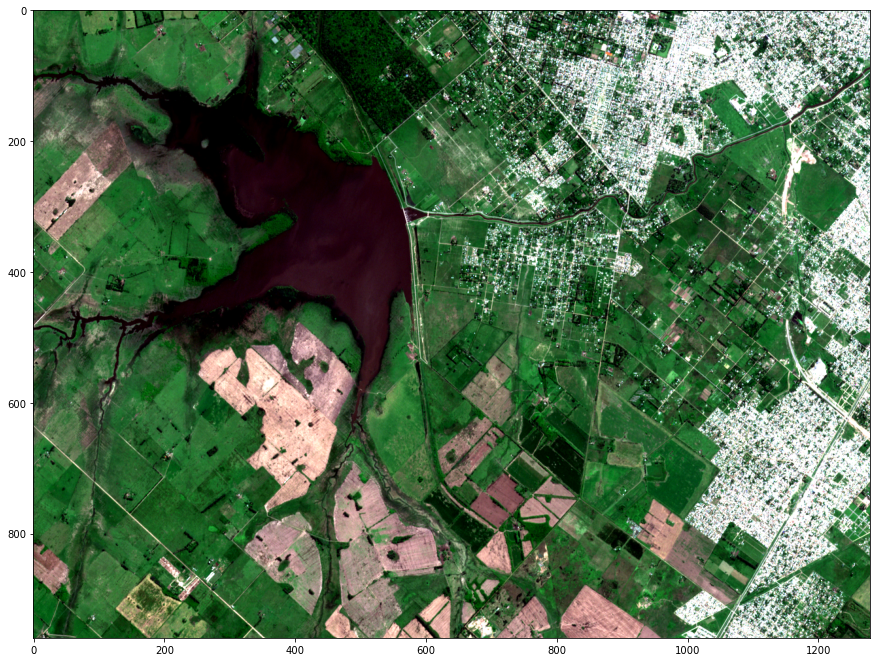

In [6]:
plt.figure(figsize=(15,15))
show(nequalize(img[[2,1,0]]))
plt.show()

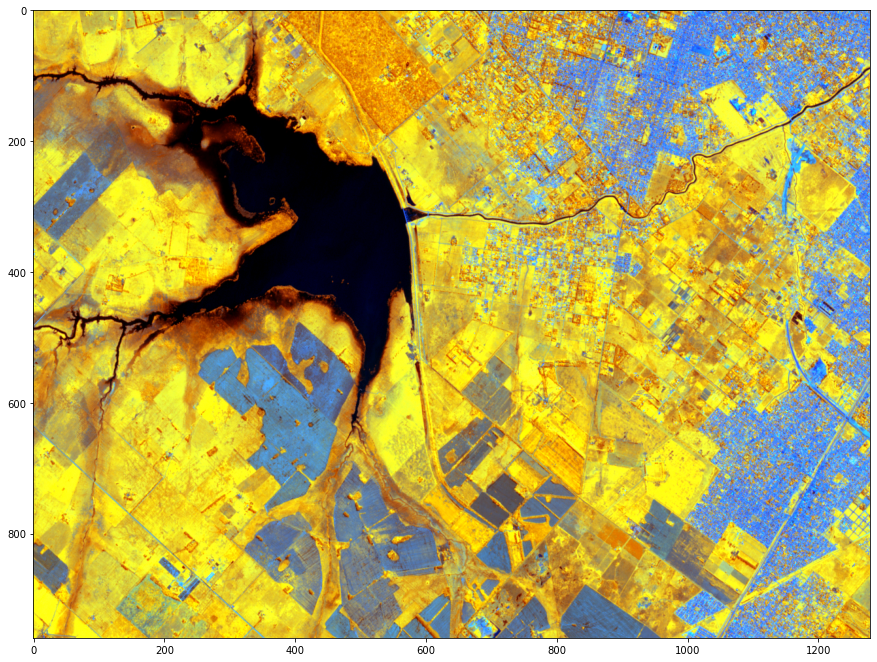

In [7]:
plt.figure(figsize=(15,15))
show(nequalize(img[[4,3,0]]))
plt.show()

## Tratemos de hacer una máscara de agua

In [8]:
NDVI = img[4]
NDVI<0.0

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

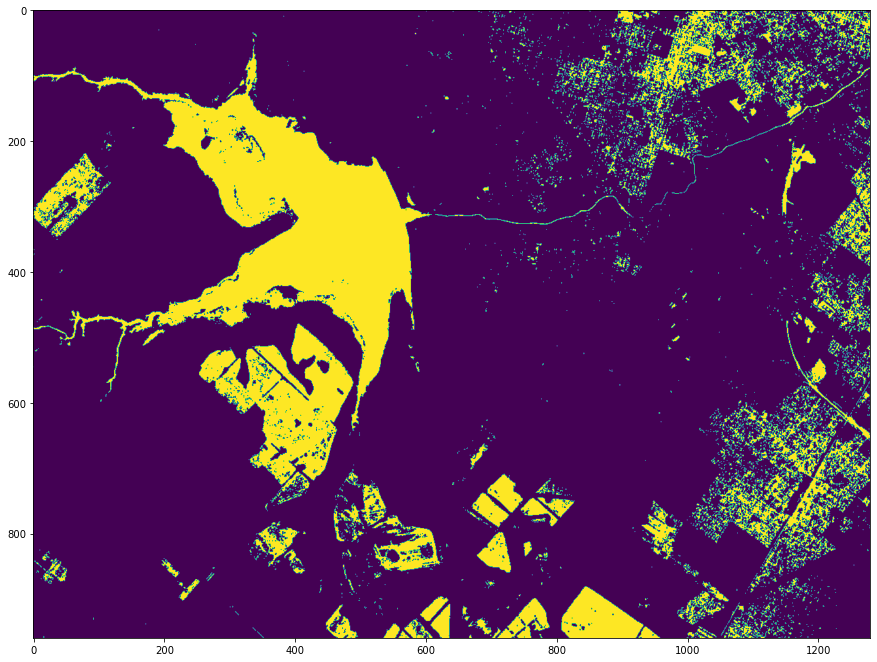

In [9]:
plt.figure(figsize=(15,15))
show(NDVI<0.25)
plt.show()

## Miremos un poco los histogramas

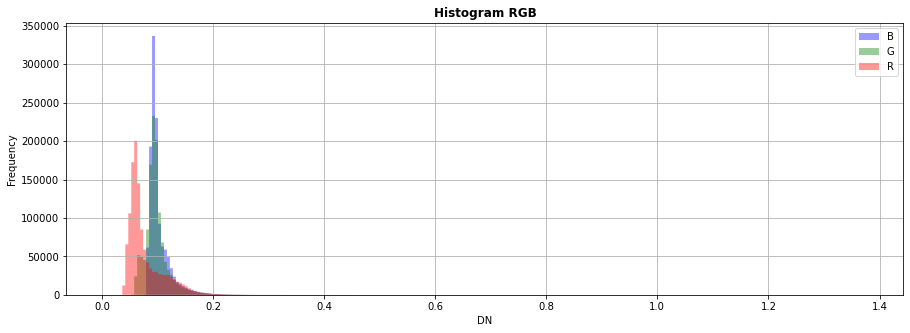

In [10]:
plt.figure(figsize=(15,5))

show_hist(
    img[[2,1,0]], bins=256, lw=0.0, alpha=0.4,
    histtype='stepfilled', title="Histogram RGB",label=['R', 'G', 'B'])
plt.show()

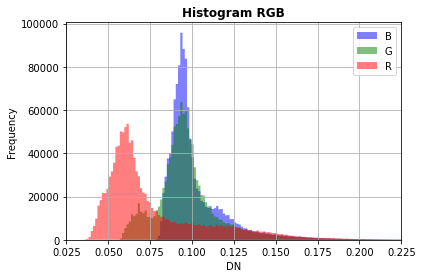

In [11]:
#O mas bonito
fig, axhist = plt.subplots(1, 1)
plt.xlim(xmin=0.025, xmax = 0.225)
show_hist(
    img[[2,1,0]], bins=1024, lw=0.0, alpha=0.5,
    histtype='stepfilled', title="Histogram RGB",ax=axhist,label=['R', 'G', 'B'])


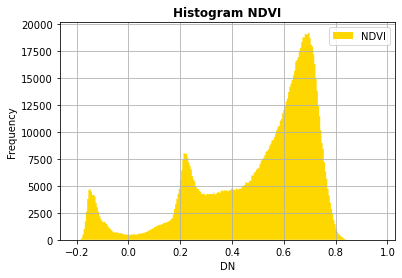

In [12]:
show_hist(
    img[-1], bins=256, lw=0.0, alpha=1,
    histtype='stepfilled', title="Histogram NDVI",label=['NDVI'])

## ¿a qué corresponde cada moda?

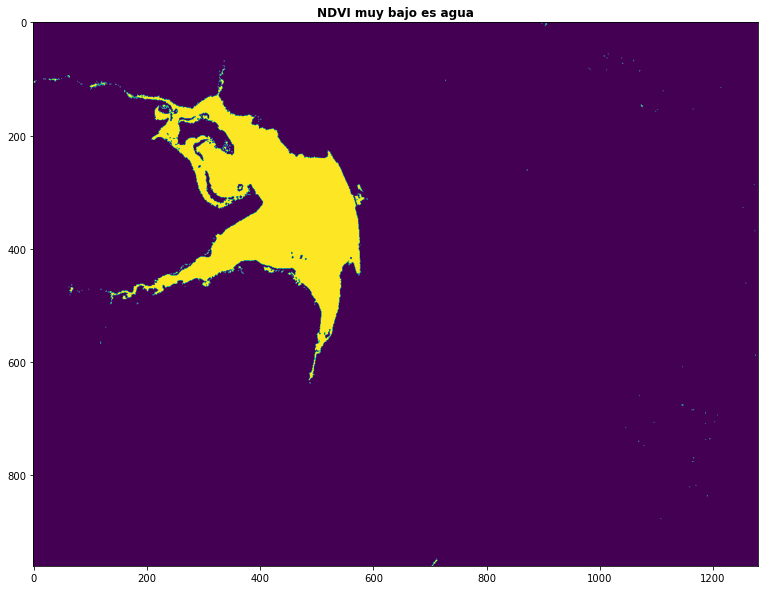

In [27]:
plt.figure(figsize=(20,10))
show(NDVI<0.0,title='NDVI muy bajo es agua')
plt.show()

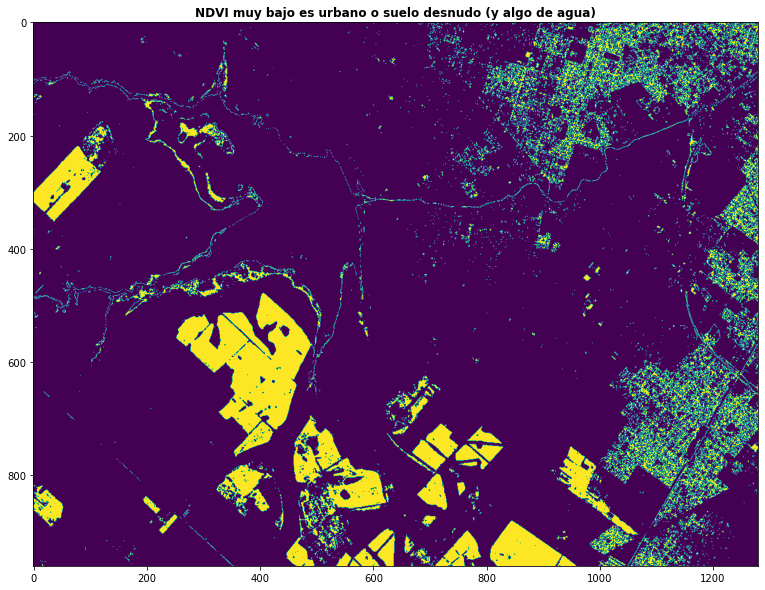

In [14]:
plt.figure(figsize=(20,10))
show((NDVI>0.15) & (NDVI<0.3),title='NDVI muy bajo es urbano o suelo desnudo (y algo de agua)')
plt.show()

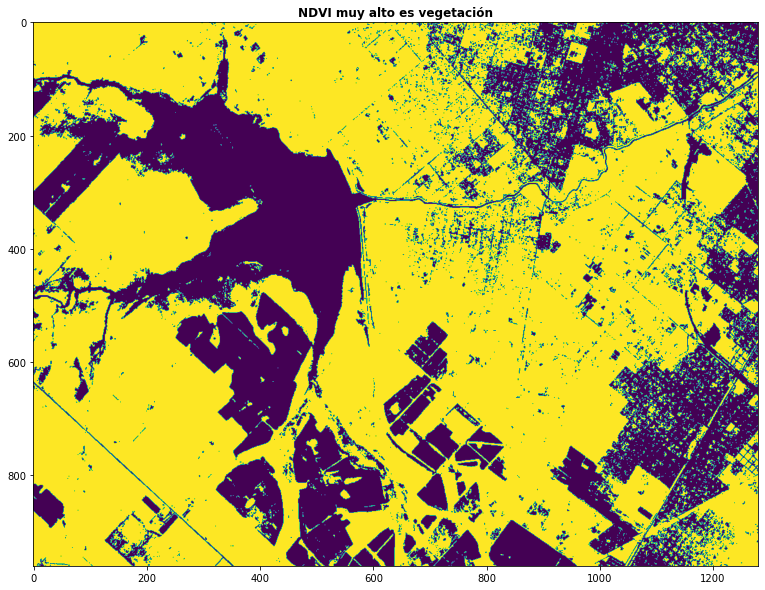

In [15]:
plt.figure(figsize=(20,10))
show(NDVI>0.45,title='NDVI muy alto es vegetación')
plt.show()

## Veamos ahora el histograma para NIR

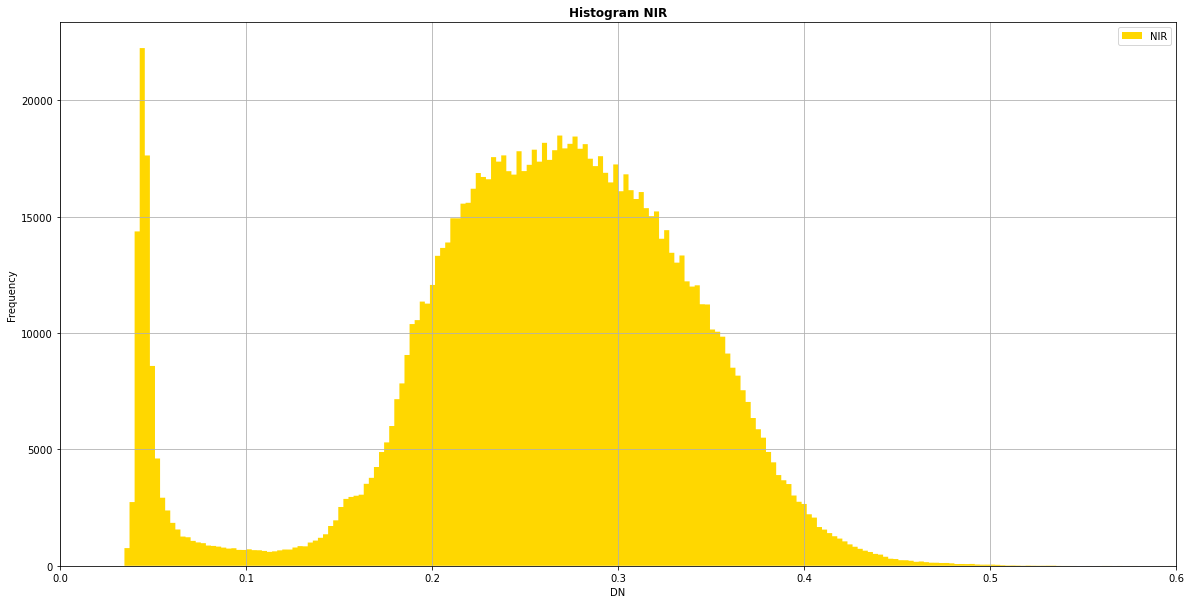

In [16]:
plt.figure(figsize=(20,10))
plt.xlim(xmin=0.0, xmax = 0.6)
show_hist(
    img[-2], bins=512, lw=0.0, alpha=1,
    histtype='stepfilled', title="Histogram NIR",label=['NIR'])  

### Ejercicio 8.1 de máscaras:
1. Resolvé:
    1. ¿A qué corresponde cada una de las dos modas del NIR en el histograma anterior?
    1. Usando un umbral en NIR o NDVI (¿cuál conviene?) generá una máscara de agua. Usá histogramas para seleccionar umbral.
    1. Usando un recorte similar al S2_dique_20181006.tif pero para la imagen del 2019-11-20, generá una máscara de agua con el umbral adecuado para esta nueva fecha.
    1. Compará ambas máscaras. ¿A qué corresponden los pixels marcados como agua en solo una de las imagenes?
    1. Armá una imagen que tenga valor 0 si no hay agua, 1 si hay agua en una de ambas fechas y 2 si hay agua en ambas fechas. Ploteá el resultado.


## Hasta acá miramos la imágen entera.
## Agreguemos ahora información (etiquetas) sobre sus pixels.

In [17]:
rois_shp = gpd.read_file(path_shp+'rois_dique.geojson')
rois_shp.head(10)

id    clase                                           geometry
0   1     agua  MULTIPOLYGON (((327627.391 6161396.182, 327560...
1   2   bosque  MULTIPOLYGON (((327996.990 6163381.143, 328118...
2   3   urbano  MULTIPOLYGON (((334008.857 6163386.371, 334573...
3   3    rural  MULTIPOLYGON (((329571.576 6156408.423, 329423...
4   4    rural  MULTIPOLYGON (((326543.687 6160726.512, 326657...
5   5   urbano  MULTIPOLYGON (((336664.534 6160607.320, 336840...
6   6  humedal  MULTIPOLYGON (((327973.465 6155108.161, 327991...
7   7  humedal  MULTIPOLYGON (((328595.824 6161485.053, 328600...
8   8  humedal  MULTIPOLYGON (((324790.574 6154479.398, 324681...
9   9  humedal  MULTIPOLYGON (((328585.369 6157966.020, 328575...

In [18]:
rois_shp[['clase']]

clase
0      agua
1    bosque
2    urbano
3     rural
4     rural
5    urbano
6   humedal
7   humedal
8   humedal
9   humedal
10    rural
11    rural
12    rural
13   bosque
14   bosque
15  humedal
16    rural

In [19]:
rois_shp['clase'][0]

'agua'

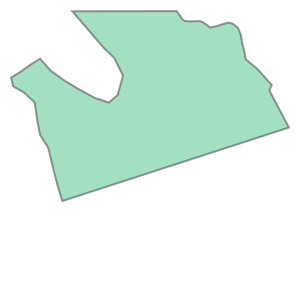

In [20]:
rois_shp['geometry'] # series of shapely geometries
rois_shp['geometry'][0]

In [21]:
print(rois_shp.crs)

epsg:32721


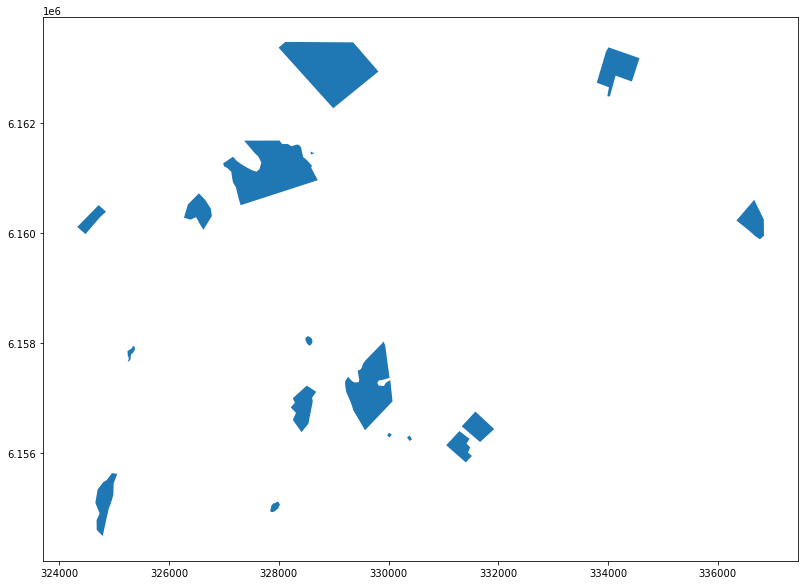

In [22]:
#plt.figure()
rois_shp.plot(figsize=(20,10))
plt.show()

## Ver en conjunto ndvi y rois

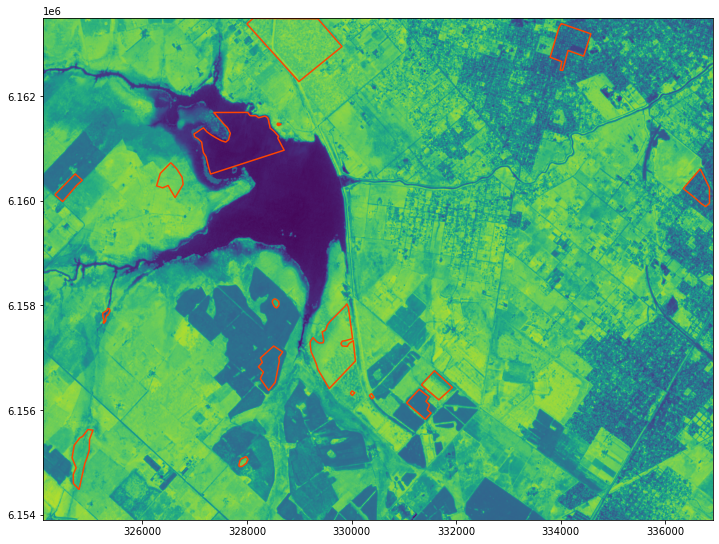

In [23]:
fig, ax = plt.subplots(figsize=(12,12))
rois_shp.boundary.plot(ax=ax, color='orangered')
show(NDVI,transform = gt, ax=ax)
plt.show()

In [24]:
print(gt)

| 10.00, 0.00, 324100.00|
| 0.00,-10.00, 6163500.00|
| 0.00, 0.00, 1.00|


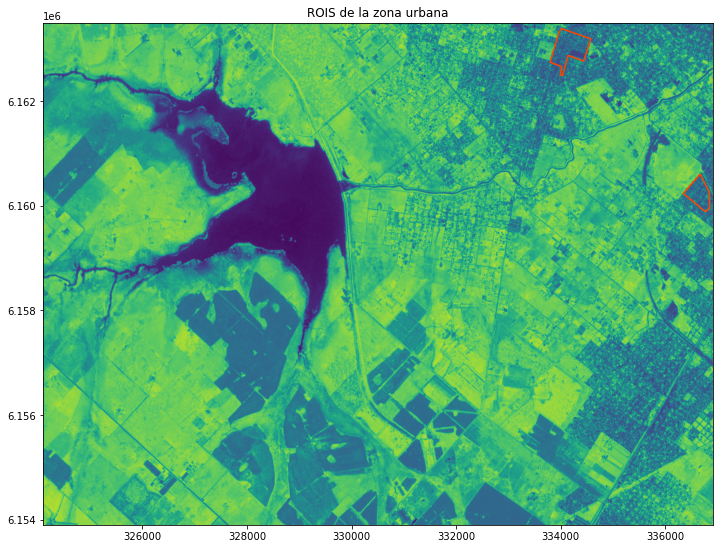

In [25]:
fig, ax = plt.subplots(figsize=(12,12))
rois_shp[rois_shp['clase']=='urbano'].boundary.plot(ax=ax, color='orangered')
show(NDVI,transform = gt, ax=ax)
plt.title('ROIS de la zona urbana')
plt.show()

## Coloreamos los ROIS por clase

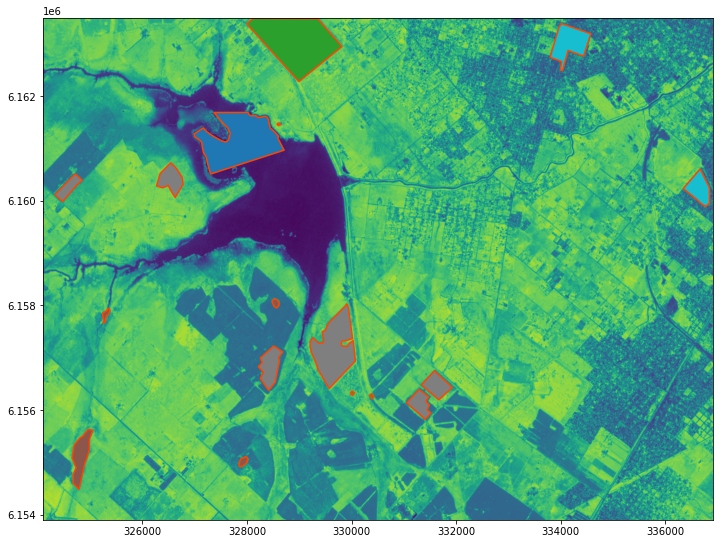

In [26]:
fig, ax = plt.subplots(figsize=(12,12))
rois_shp.plot(ax=ax, column='clase')
rois_shp.boundary.plot(ax=ax, color='orangered')
show(NDVI,transform = gt, ax=ax)
plt.show()

### Ejercicio 8.2 Visualización de imágenes:
1. Rehacé el gráfico usando de fondo la imagen RGB equalizada y ploteando los bordes de los ROIS.
1. Rehacé el gráfico pero ploteando solo los ROIs de clase 'rural'.